# 1.Import Library

In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers,Sequential,losses,optimizers,datasets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

def setup_seed(seed):
    random.seed(seed)  # 为python设置随机种子
    np.random.seed(seed)  # 为numpy设置随机种子
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first

setup_seed(2020)


seed = 2020
random.seed = 2020
np.random.seed = 2020
tf.seed = 2020
tf.random.set_seed(2020)

# 2.Data processing

In [2]:
import scipy.io as scio
import pandas as pd

#input
feature1 = r'\Training dataset\ACC_UD.mat'
data1 = scio.loadmat(feature1)
AA=data1['ACC_UD']
A=AA[:,0:300]

feature2 = r'\Training dataset\ACC_EW.mat'
data2 = scio.loadmat(feature2)
BB=data2['ACC_EW']
B=BB[:,0:300]

feature3 = r'\Training dataset\ACC_NS.mat'
data3 = scio.loadmat(feature3)
CC=data3['ACC_NS']
C=CC[:,0:300]

feature4 = r'\Training dataset\VEL_UD.mat'
data4 = scio.loadmat(feature4)
DD=data4['VEL_UD']
D=DD[:,0:300]

feature5 = r'\Training dataset\VEL_EW.mat'
data5 = scio.loadmat(feature5)
EE=data5['VEL_EW']
E=EE[:,0:300]

feature6 = r'\Training dataset\VEL_NS.mat'
data6 = scio.loadmat(feature6)
FF=data6['VEL_NS']
F=FF[:,0:300]

feature7 = r'\Training dataset\DIS_UD.mat'
data7 = scio.loadmat(feature7)
GG=data7['DIS_UD']
G=GG[:,0:300]

feature8 = r'\Training dataset\DIS_EW.mat'
data8 = scio.loadmat(feature8)
HH=data8['DIS_EW']
H=HH[:,0:300]

feature9 = r'\Training dataset\DIS_NS.mat'
data9 = scio.loadmat(feature9)
II=data9['DIS_NS']
I=II[:,0:300]


label = pd.read_csv(open(r'\Training dataset\lable.csv',encoding='UTF-8'))


In [3]:
raw_data1=np.hstack((A,B))
raw_data2=np.hstack((raw_data1,C))
raw_data3=np.hstack((raw_data2,D))
raw_data4=np.hstack((raw_data3,E))
raw_data5=np.hstack((raw_data4,F))
raw_data6=np.hstack((raw_data5,G))
raw_data7=np.hstack((raw_data6,H))
train_xx=np.hstack((raw_data7,I))

#print(train_xx.shape)


y_data=label.iloc[:,[1,3]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(y_data[0])
#print(y_data.shape)

In [4]:
train_y=y_data[:,[1]] #y_train_lable
dis_train=y_data[:,[0]] #train_site_distance


#print(train_y.shape)
#print(dis_train.shape)



In [5]:
train_x=[]
for i in range(len(train_xx)):
    train_x.append(np.array(train_xx[i].reshape(9,1,300)).T)

In [6]:
train_dis=[]
for i in range(len(dis_train)):
    train_dis.append(np.array(dis_train[i].reshape(1,1,1)).T)

In [7]:
train_x=np.array(train_x)
train_dis=np.array(train_dis)
#test_x=np.array(test_x)

In [8]:
#3#  ##Reshaping
train_x = np.reshape(train_x, (train_x.shape[0], 300, 9))
train_dis = np.reshape(train_dis, (train_dis.shape[0], 1, 1))
#test_x = np.reshape(test_x, (test_x.shape[0], 300, 9))
#print("0",train_x.shape[0])
#print("1",train_x.shape[1])
#print(train_x.shape)
#print(train_x)

# 3. EEWCAN-Mag architecture, training and testing

In [9]:
from keras import backend as K
from keras.engine.topology import Layer
class Self_Attention(Layer):
 
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Self_Attention, self).__init__(**kwargs)
 
    def build(self, input_shape):
        # 为该层创建一个可训练的权重
        #inputs.shape = (batch_size, time_steps, seq_len)
        self.kernel = self.add_weight(name='kernel',
                                      shape=(3,input_shape[2], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
 
        super(Self_Attention, self).build(input_shape)  # 一定要在最后调用它
 
    def call(self, x):
        WQ = K.dot(x, self.kernel[0])
        WK = K.dot(x, self.kernel[1])
        WV = K.dot(x, self.kernel[2])
 
        print("WQ.shape",WQ.shape)
 
        print("K.permute_dimensions(WK, [0, 2, 1]).shape",K.permute_dimensions(WK, [0, 2, 1]).shape)
 
 
        QK = K.batch_dot(WQ,K.permute_dimensions(WK, [0, 2, 1]))
 
        QK = QK / (64**0.5)
 
        QK = K.softmax(QK)
 
        print("QK.shape",QK.shape)
 
        V = K.batch_dot(QK,WV)
 
        return V
 
    def compute_output_shape(self, input_shape):
 
        return (input_shape[0],input_shape[1],self.output_dim)

    def get_config(self):  #在有自定义网络层时，需要保存模型时，重写get_config函数
        config = {"output_dim": self.output_dim}
        base_config = super(Self_Attention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [10]:
# 定义一个局部注意力层（适用于序列数据）
import tensorflow as tf
from tensorflow.keras import layers

class LocalAttentionLayer(layers.Layer):
    def __init__(self, window_size, units, **kwargs):
        super(LocalAttentionLayer, self).__init__(**kwargs)
        self.window_size = window_size  # 注意力窗口大小（如5, 7）
        self.units = units
        
        # 局部特征提取层：一维卷积替代全连接，限制感受野为窗口大小
        self.conv1 = layers.Conv1D(
            filters=units, 
            kernel_size=window_size, 
            padding='same',  # 保持序列长度不变
            activation='tanh'
        )
        
        # 注意力权重生成层：卷积核为1，输出单通道注意力得分
        self.conv2 = layers.Conv1D(
            filters=1, 
            kernel_size=1,  # 仅融合通道信息，不改变空间范围
            activation='softmax'  # 窗口内归一化
        )
        
        self.mul = layers.Multiply()

    def call(self, inputs, mask=None):
        # 输入形状: [batch_size, seq_len, features]
        
        # Step 1: 通过卷积提取局部特征（窗口内信息）
        # 输出形状: [batch_size, seq_len, units]
        local_features = self.conv1(inputs)  # 卷积核覆盖窗口大小区域
        
        # Step 2: 生成局部注意力权重（每个位置仅关注窗口内邻居）
        # 输出形状: [batch_size, seq_len, 1]
        attention_weights = self.conv2(local_features)  # 窗口内权重归一化
        
        # Step 3: 加权求和（仅窗口内特征参与）
        # 输入与注意力权重逐元素相乘后求和
        weighted_sum = self.mul([inputs, attention_weights])
        weighted_sum = tf.reduce_sum(weighted_sum, axis=1)  # 形状: [batch_size, features]
        
        return weighted_sum

    def get_config(self):
        config = super().get_config()
        config.update({
            "window_size": self.window_size,
            "units": self.units
        })
        return config

In [11]:
# 定义一个全局注意力层（适用于序列数据）
class Attention(Layer):
    def __init__(self,**kwargs):
        super(Attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.weight = self.add_weight(name="watt", shape=(input_shape[-1], 1), initializer="normal")
        self.bias = self.add_weight(name="batt", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)
 
    def call(self,x):
        att = K.expand_dims(K.softmax(K.squeeze(K.tanh(K.dot(x,self.weight) + self.bias), axis=-1)), axis=-1)
        return K.sum(x*att, axis=1)
 
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[-1])
 
    def get_config(self):
        return super(Attention,self).get_config()

In [12]:
def LocalEncoder(x):
    e = Conv1D(32, 3, padding = 'same')(x)
    e = ReLU()(e)
    e = MaxPooling1D(4, padding='same')(e)
    e = Dropout(0.2)(e)
    
     

#    e = Bidirectional(GRU(256, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(e)
    e = Bidirectional(GRU(128, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(e)
    e = Bidirectional(GRU(128, return_sequences=False, dropout=0.0, recurrent_dropout=0.0))(e)
    
    e = LocalAttentionLayer(128)(e)
    
    return e
    
    

In [13]:
def GlobalEncoder(x):
    e = Conv1D(64, 3, padding = 'same')(x) 
    e = ReLU()(e)
    e = MaxPooling1D(4, padding='same')(e)
    e = Dropout(0.2)(e)
    

    


#    e = Bidirectional(GRU(256, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(e)
    e = Bidirectional(GRU(32, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(e)
    e = Bidirectional(GRU(32, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(e)
    
    e = Attention()(e)
    
    return e

In [14]:
seed=50
#50 17.20 1.32
drop_rate = 0.2
def get_model():

    inp1 = Input(shape=(300, 9), name='input_layer') 

    x1 = LocalEncoder(inp1)
    x2 = GlobalEncoder(inp1)

    inp2 = tf.keras.layers.Input(shape=(1,1))   #加入场地放大系数和震中距
    x3 = tf.keras.layers.Flatten()(inp2) # 打平层，方便全连接层处理   
    
    e = tf.keras.layers.Concatenate()([x1,x2,x3])


#    e = Dense(256, activation='relu')(concat)#relu
    e = Dense(128, activation='relu')(e)#relu
    e = Dense(1)(e)
    o = Activation('linear', name='output_layer')(e)
    

    #model = Model([inp_seq, inp_lap, inp_feat], out)  ,inpt2
    rms = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model = Model([inp1,inp2], o)
    model.compile(optimizer = rms, loss = 'mean_squared_error')

    return model

In [15]:
model = get_model()
model.summary() 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 300, 9)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 300, 32)      896         input_layer[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 300, 64)      1792        input_layer[0][0]                
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 300, 32)      0           conv1d[0][0]                     
_______________________________________________________________________________________

In [16]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(monitor="val_loss",
                               factor=0.1,
                                cooldown= 0,
                                patience= 5,
                                min_lr=0.1e-7)
early_stopping_monitor = EarlyStopping(monitor= 'val_loss', patience = 10) #10  17.20 1.32
callbacks = [lr_reducer, early_stopping_monitor]




model = get_model()
history=model.fit([train_x,train_dis], train_y, epochs=300, batch_size=256,  
            validation_split=0.1, callbacks=callbacks)  #256 ,train_physics  ,test_physics ,train_physics

pred_train_all = model.predict([train_x,train_dis]).ravel()
#pred_test_all = model.predict(test_x).ravel()  ##ravel() 转换成1列


#pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
#reverse_valid = scaler_seq.inverse_transform(y_valid)
#pred_test_all = scaler_seq.inverse_transform(pred_test_all)
#reverse_test = scaler_seq.inverse_transform(y_test)

Epoch 1/300
162/162 [==============================] - 27s 169ms/step - loss: 1.2107 - val_loss: 0.4153
Epoch 2/300
162/162 [==============================] - 31s 190ms/step - loss: 0.3394 - val_loss: 0.3612
Epoch 3/300
162/162 [==============================] - 31s 191ms/step - loss: 0.2795 - val_loss: 0.2692
Epoch 4/300
162/162 [==============================] - 31s 194ms/step - loss: 0.2305 - val_loss: 0.2123
Epoch 5/300
162/162 [==============================] - 31s 193ms/step - loss: 0.2030 - val_loss: 0.1882
Epoch 6/300
162/162 [==============================] - 31s 191ms/step - loss: 0.1718 - val_loss: 0.1705
Epoch 7/300
162/162 [==============================] - 31s 191ms/step - loss: 0.1526 - val_loss: 0.1518
Epoch 8/300
162/162 [==============================] - 31s 191ms/step - loss: 0.1421 - val_loss: 0.1365
Epoch 9/300
162/162 [==============================] - 31s 191ms/step - loss: 0.1375 - val_loss: 0.1437
Epoch 10/300
162/162 [==============================] - 31s 191m

In [17]:
# 保存权重（推荐方式）
model.save_weights("EEWCAN_Mag_weights.h5")  # HDF5格式

Text(0, 0.5, 'Loss')

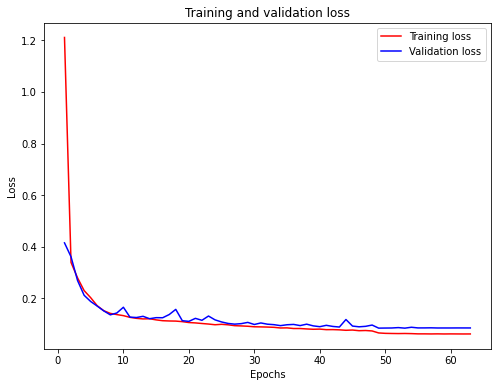

In [19]:
from matplotlib.pyplot import plot,savefig
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1,len(loss)+1)
plt.figure(figsize=(8, 6))

#plt.semilogy(epoch,loss, color="red",label='Training loss')
#plt.semilogy(epoch, val_loss,color="blue", label='Validation loss')

plt.plot(epoch,loss, color="red",label='Training loss')
plt.plot(epoch, val_loss,color="blue", label='Validation loss')


plt.legend()
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [18]:
loss=np.array(loss)
val_loss=np.array(val_loss)
epoch=np.array(epoch)

loss=loss.reshape(loss.shape[0],1)
val_loss=val_loss.reshape(val_loss.shape[0],1)
epoch=epoch.reshape(epoch.shape[0],1)

loss_zong=np.concatenate((epoch,loss,val_loss),axis=1)


print(epoch.shape)
print(val_loss.shape)
print(loss.shape)
print(loss_zong.shape)

data_loss = pd.DataFrame(loss_zong) #将数组转换为dataframe结构
data_loss.columns=['epoch','loss','val_loss']
writer_loss = pd.ExcelWriter(r'\EEWCAN\Magloss.xls')   # 写入Excel文件

data_loss.to_excel(writer_loss,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_loss.save()
writer_loss.close()

(63, 1)
(63, 1)
(63, 1)
(63, 3)


# 4.Model memory

In [18]:
def get_model_size_mb(model):
    params = model.count_params()
    # 假设所有参数为float32（4字节）
    size_mb = params * 4 / 1024**2
    return size_mb
 
print("Model size (MB):", get_model_size_mb(model))

Model size (MB): 2.043506622314453


# 5. Training results

训练标准差STD= 0.24900837748565613
训练误差均值MEAN= -0.020452953675030746
训练平均绝对误差MAE= 0.186720284131278
训练RMSE= 0.24984694389179943
训练MAPE= 4.336475244353982
训练r2 score: 0.9390880976122641


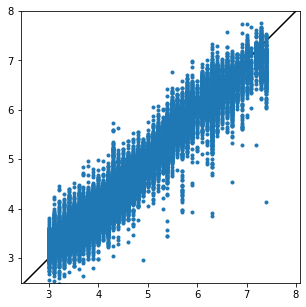

In [20]:
from sklearn import metrics
from sklearn.metrics import r2_score
print("训练标准差STD=",np.std(pred_train_all-train_y.ravel()))
print("训练误差均值MEAN=",np.mean(pred_train_all-train_y.ravel()))
print("训练平均绝对误差MAE=",metrics.mean_absolute_error(pred_train_all, train_y.ravel()))
print("训练RMSE=",metrics.mean_squared_error(pred_train_all, train_y.ravel())**0.5)
print("训练MAPE=",np.mean(np.abs((train_y.ravel() - pred_train_all) / train_y.ravel())) * 100)
print("训练r2 score:", r2_score(train_y.ravel(), pred_train_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(2.5, 8, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(train_y.ravel(),pred_train_all,'.')
plt.xlim(2.5, 8)
plt.ylim(2.5, 8)
plt.show()

In [21]:
#########################保存训练结果####################################
pred_train_all=pred_train_all.reshape(pred_train_all.shape[0],1)

#y_score_tr=y_score_tr.reshape(y_score_tr.shape[0],1)
#print(pred_train_all.shape)
#print(train_y.shape)

tr_result=np.concatenate((train_y,pred_train_all),axis=1)

#print(tr_result.shape)

data_tr = pd.DataFrame(tr_result) #将数组转换为dataframe结构
data_tr.columns=['True M','Pred M']
writer_tr = pd.ExcelWriter(r'\EEWCAN\Magtrain.xls')   # 写入Excel文件

data_tr.to_excel(writer_tr,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tr.save()
writer_tr.close()
#########################保存训练结果####################################

# 6. Test Results

In [22]:
#震例
import scipy.io as scio
import pandas as pd

#input
feature1z = r'\Test dataset\ACC_UD.mat'
data1z = scio.loadmat(feature1z)
AAz=data1z['ACC_UD']
Az=AAz[:,0:300]

feature2z = r'\Test dataset\ACC_EW.mat'
data2z = scio.loadmat(feature2z)
BBz=data2z['ACC_EW']
Bz=BBz[:,0:300]

feature3z = r'\Test dataset\ACC_NS.mat'
data3z = scio.loadmat(feature3z)
CCz=data3z['ACC_NS']
Cz=CCz[:,0:300]

feature4z = r'\Test dataset\VEL_UD.mat'
data4z = scio.loadmat(feature4z)
DDz=data4z['VEL_UD']
Dz=DDz[:,0:300]

feature5z = r'\Test dataset\VEL_EW.mat'
data5z = scio.loadmat(feature5z)
EEz=data5z['VEL_EW']
Ez=EEz[:,0:300]

feature6z = r'\Test dataset\VEL_NS.mat'
data6z = scio.loadmat(feature6z)
FFz=data6z['VEL_NS']
Fz=FFz[:,0:300]

feature7z = r'\Test dataset\DIS_UD.mat'
data7z = scio.loadmat(feature7z)
GGz=data7z['DIS_UD']
Gz=GGz[:,0:300]

feature8z = r'\Test dataset\DIS_EW.mat'
data8z = scio.loadmat(feature8z)
HHz=data8z['DIS_EW']
Hz=HHz[:,0:300]

feature9z = r'\Test dataset\DIS_NS.mat'
data9z = scio.loadmat(feature9z)
IIz=data9z['DIS_NS']
Iz=IIz[:,0:300]


labelz = pd.read_csv(open(r'\Test dataset\lable.csv',encoding='UTF-8'))


In [23]:
raw_data1z=np.hstack((Az,Bz))
raw_data2z=np.hstack((raw_data1z,Cz))
raw_data3z=np.hstack((raw_data2z,Dz))
raw_data4z=np.hstack((raw_data3z,Ez))
raw_data5z=np.hstack((raw_data4z,Fz))
raw_data6z=np.hstack((raw_data5z,Gz))
raw_data7z=np.hstack((raw_data6z,Hz))
x_dataz=np.hstack((raw_data7z,Iz))

y_dataz=labelz.iloc[:,[2,3]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(y_dataz[0])
#print(y_dataz.shape)

In [24]:
zhenli_y=y_dataz[:,[1]] #y_train_lable
dis_zhenli=y_dataz[:,[0]] #train_site_distance



In [25]:
zhenli_x=[]
for i in range(len(x_dataz)):
    zhenli_x.append(np.array(x_dataz[i].reshape(9,1,300)).T)

In [26]:
zhenli_dis=[]
for i in range(len(dis_zhenli)):
    zhenli_dis.append(np.array(dis_zhenli[i].reshape(1,1,1)).T)



In [27]:
zhenli_x=np.array(zhenli_x)
zhenli_dis=np.array(zhenli_dis)

In [28]:
zhenli_x = np.reshape(zhenli_x, (zhenli_x.shape[0], 300, 9))
zhenli_dis = np.reshape(zhenli_dis, (zhenli_dis.shape[0], 1, 1))

震例标准差STD= 0.3305882985907964
震例误差均值MEAN= -0.07391078100801379
震例平均绝对误差MAE= 0.25794204210610366
震例RMSE= 0.33874979957834983
震例MAPE= 6.001308312152702
震例r2 score: 0.8807117179380876


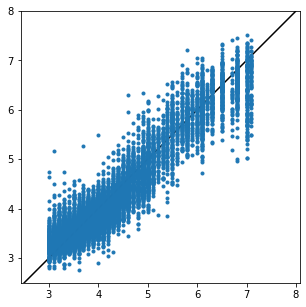

In [29]:
pred_zhenli_all = model.predict([zhenli_x,zhenli_dis]).ravel()  ##ravel() 转换成1列
print("震例标准差STD=",np.std(pred_zhenli_all-zhenli_y.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all-zhenli_y.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all, zhenli_y.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all, zhenli_y.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y.ravel() - pred_zhenli_all) / zhenli_y.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y.ravel(), pred_zhenli_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(2.5, 8, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y.ravel(),pred_zhenli_all,'.')
plt.xlim(2.5, 8)
plt.ylim(2.5, 8)
plt.show()  

In [30]:
#########################保存震例结果####################################
pred_zhenli_all=pred_zhenli_all.reshape(pred_zhenli_all.shape[0],1)

#print(pred_zhenli_all.shape)
#print(zhenli_y.shape)

tz_result=np.concatenate((zhenli_y,pred_zhenli_all),axis=1)

#print(tz_result.shape)

data_tz = pd.DataFrame(tz_result) #将数组转换为dataframe结构
data_tz.columns=['True M','Pred M']
writer_tz = pd.ExcelWriter(r'\EEWCAN\Magtest.xls')   # 写入Excel文件

data_tz.to_excel(writer_tz,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tz.save()
writer_tz.close()
#########################保存震例结果####################################

# 7.Inference latency for each sample

In [27]:
zhenli_x1=zhenli_x[0]
zhenli_x1=zhenli_x1.reshape(1, 300, 9)

zhenli_dis1=zhenli_dis[0]
zhenli_dis1=zhenli_dis1.reshape(1,1)
print(zhenli_x1.shape)
print(zhenli_dis1.shape)

(1, 300, 9)
(1, 1)


In [29]:
import time
start_time = time.perf_counter()  # 记录开始时间
pred_zhenli_all = model.predict([zhenli_x1,zhenli_dis1]).ravel()  ##ravel() 转换成1列
end_time = time.perf_counter()  # 记录结束时间
elapsed_time_ms = (end_time - start_time) * 1000  # 转换为毫秒
print(f"Elapsed time: {elapsed_time_ms:.2f} ms")

Elapsed time: 73.15 ms


# 8. Test on the Chinese strong-ground motion data

In [31]:
#中国地区应用
import scipy.io as scio
import pandas as pd

#input
feature1z_CH = r'\Chinese strong-ground motion test dataset\ACC_UD.mat'
data1z_CH = scio.loadmat(feature1z_CH)
AAz_CH=data1z_CH['ACC_UD']
Az_CH=AAz_CH[:,0:300]

feature2z_CH = r'\Chinese strong-ground motion test dataset\ACC_EW.mat'
data2z_CH = scio.loadmat(feature2z_CH)
BBz_CH=data2z_CH['ACC_EW']
Bz_CH=BBz_CH[:,0:300]

feature3z_CH = r'\Chinese strong-ground motion test dataset\ACC_NS.mat'
data3z_CH = scio.loadmat(feature3z_CH)
CCz_CH=data3z_CH['ACC_NS']
Cz_CH=CCz_CH[:,0:300]

feature4z_CH = r'\Chinese strong-ground motion test dataset\VEL_UD.mat'
data4z_CH = scio.loadmat(feature4z_CH)
DDz_CH=data4z_CH['VEL_UD']
Dz_CH=DDz_CH[:,0:300]

feature5z_CH = r'\Chinese strong-ground motion test dataset\VEL_EW.mat'
data5z_CH = scio.loadmat(feature5z_CH)
EEz_CH=data5z_CH['VEL_EW']
Ez_CH=EEz_CH[:,0:300]

feature6z_CH = r'\Chinese strong-ground motion test dataset\VEL_NS.mat'
data6z_CH = scio.loadmat(feature6z_CH)
FFz_CH=data6z_CH['VEL_NS']
Fz_CH=FFz_CH[:,0:300]

feature7z_CH = r'\Chinese strong-ground motion test dataset\DIS_UD.mat'
data7z_CH = scio.loadmat(feature7z_CH)
GGz_CH=data7z_CH['DIS_UD']
Gz_CH=GGz_CH[:,0:300]

feature8z_CH = r'\Chinese strong-ground motion test dataset\DIS_EW.mat'
data8z_CH = scio.loadmat(feature8z_CH)
HHz_CH=data8z_CH['DIS_EW']
Hz_CH=HHz_CH[:,0:300]

feature9z_CH = r'\Chinese strong-ground motion test dataset\DIS_NS.mat'
data9z_CH = scio.loadmat(feature9z_CH)
IIz_CH=data9z_CH['DIS_NS']
Iz_CH=IIz_CH[:,0:300]


labelz_CH = pd.read_csv(open(r'\Chinese strong-ground motion test dataset\lable.csv',encoding='UTF-8'))

In [32]:
raw_data1z_CH=np.hstack((Az_CH,Bz_CH))
raw_data2z_CH=np.hstack((raw_data1z_CH,Cz_CH))
raw_data3z_CH=np.hstack((raw_data2z_CH,Dz_CH))
raw_data4z_CH=np.hstack((raw_data3z_CH,Ez_CH))
raw_data5z_CH=np.hstack((raw_data4z_CH,Fz_CH))
raw_data6z_CH=np.hstack((raw_data5z_CH,Gz_CH))
raw_data7z_CH=np.hstack((raw_data6z_CH,Hz_CH))
x_dataz_CH=np.hstack((raw_data7z_CH,Iz_CH))

y_dataz_CH=labelz_CH.iloc[:,[2,3]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(y_dataz_CH[0])
#print(y_dataz_CH.shape)

In [33]:
zhenli_y_CH=y_dataz_CH[:,[1]] #y_train_lable
dis_zhenli_CH=y_dataz_CH[:,[0]] #train_site_distance

In [34]:
zhenli_x_CH=[]
for i in range(len(x_dataz_CH)):
    zhenli_x_CH.append(np.array(x_dataz_CH[i].reshape(9,1,300)).T)

In [35]:
zhenli_dis_CH=[]
for i in range(len(dis_zhenli_CH)):
    zhenli_dis_CH.append(np.array(dis_zhenli_CH[i].reshape(1,1,1)).T)

In [36]:
zhenli_x_CH=np.array(zhenli_x_CH)
zhenli_dis_CH=np.array(zhenli_dis_CH)

In [37]:
zhenli_x_CH = np.reshape(zhenli_x_CH, (zhenli_x_CH.shape[0], 300, 9))
zhenli_dis_CH = np.reshape(zhenli_dis_CH, (zhenli_dis_CH.shape[0], 1, 1))

震例标准差STD= 0.3580903970010211
震例误差均值MEAN= 0.17905826014214135
震例平均绝对误差MAE= 0.3178833879262773
震例RMSE= 0.40036307640625357
震例MAPE= 7.41497162974359
震例r2 score: 0.7496778363974572


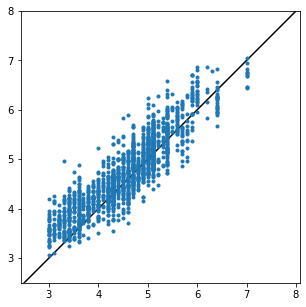

In [38]:
pred_zhenli_all_CH = model.predict([zhenli_x_CH,zhenli_dis_CH]).ravel()  ##ravel() 转换成1列
print("震例标准差STD=",np.std(pred_zhenli_all_CH-zhenli_y_CH.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all_CH-zhenli_y_CH.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all_CH, zhenli_y_CH.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all_CH, zhenli_y_CH.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y_CH.ravel() - pred_zhenli_all_CH) / zhenli_y_CH.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y_CH.ravel(), pred_zhenli_all_CH))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(2.5, 8, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y_CH.ravel(),pred_zhenli_all_CH,'.')
plt.xlim(2.5, 8)
plt.ylim(2.5, 8)
plt.show()  

In [39]:
#########################保存震例结果####################################
pred_zhenli_all_CH=pred_zhenli_all_CH.reshape(pred_zhenli_all_CH.shape[0],1)

#print(pred_zhenli_all_CH.shape)
#print(zhenli_y_CH.shape)

tz_result_CH=np.concatenate((zhenli_y_CH,pred_zhenli_all_CH),axis=1)

#print(tz_result_CH.shape)

data_tz_CH = pd.DataFrame(tz_result_CH) #将数组转换为dataframe结构
data_tz_CH.columns=['True M','Pred M']
writer_tz_CH = pd.ExcelWriter(r'\CAN\MagtestChina.xls')   # 写入Excel文件

data_tz_CH.to_excel(writer_tz_CH,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tz_CH.save()
writer_tz_CH.close()
#########################保存震例结果####################################